In [11]:
import os
import pyspark
from pyspark.sql import SparkSession, types
from pyspark.sql import functions as F, Window
from pyspark.sql.functions import col

In [4]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName('test') \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/16 06:44:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [12]:
from pyspark.sql.functions import udf


def udf_if_outlier(val, avg, stddev):
    try:
        if ( 
            (val > (avg + stddev)) 
            
        ):
            return 1
        elif (
            (val < (avg - stddev)) 
        ):
            return -1
    except Exception as e:
        # print(f'e = {e}\n val = {val}, avg = {avg}, stddev = {stddev}')
        return -2
    return 0




def udf_if_outlier_high_only(val, avg, stddev):
    try:
        if ( val > (avg + stddev)):
            return True
    except Exception as e:
        return False
    return False


def window_create(df, on_column ,number_of_days, both=1):
    w = Window.partitionBy('company').orderBy('date').rowsBetween(Window.currentRow+1, number_of_days)
    
    avg_column = f'avg_{on_column}_{number_of_days}'
    stddev_column = f'stddev_{on_column}_{number_of_days}'
    outlier_column = f'if_outlier_{on_column}_{number_of_days}'

    df = df.withColumn(
        avg_column, 
        F.avg(f'{on_column}').over(w))
    
    df = df.withColumn(
        stddev_column, 
        F.stddev(f'{on_column}').over(w))
    
    if both:
        udfValueToOutlier = udf(udf_if_outlier, types.IntegerType())
    else:
        udfValueToOutlier = udf(udf_if_outlier_high_only, types.BooleanType())
     
    # here does not work
    
    df = df.withColumn(
            outlier_column, 
            udfValueToOutlier(df[f'{on_column}'], df[f'{avg_column}'], df[f'{stddev_column}']))
    
    df.select(\
          col("company"), col(outlier_column)
    ).groupBy('company', outlier_column).count().orderBy(col("company")).show()
    
    return df


path = 'data/price_n_volume/202*/*.parquet'
df = spark.read \
        .option("header", "true") \
        .parquet(path)\
        .drop('__index_level_0__')

# df.toPandas().head()

+-------+----------------------------------+-----+
|company|if_outlier_close_percent_change_20|count|
+-------+----------------------------------+-----+
|   AAPL|                                -2|    2|
|   AAPL|                                 0|  556|
|   AAPL|                                 1|  141|
|   AAPL|                                -1|  123|
|   ABNB|                                -1|   94|
|   ABNB|                                 1|   99|
|   ABNB|                                -2|    3|
|   ABNB|                                 0|  384|
|   ADBE|                                 1|  142|
|   ADBE|                                -1|  123|
|   ADBE|                                -2|    2|
|   ADBE|                                 0|  551|
|    ADI|                                 1|  131|
|    ADI|                                -1|  132|
|    ADI|                                -2|    2|
|    ADI|                                 0|  557|
|    AEP|                      

In [13]:
df = window_create(df, 'close_percent_change', 20)
days = 50
df = window_create(df, 'close_percent_change', days)
days = 50
df = window_create(df, 'volume', days, both=0)
days = 100
df = window_create(df, 'volume', days, both=0)
days = 200
df = window_create(df, 'volume', days, both=0)

+-------+----------------------------------+-----+
|company|if_outlier_close_percent_change_20|count|
+-------+----------------------------------+-----+
|   AAPL|                                -2|    2|
|   AAPL|                                 0|  556|
|   AAPL|                                 1|  141|
|   AAPL|                                -1|  123|
|   ABNB|                                -1|   94|
|   ABNB|                                 1|   99|
|   ABNB|                                -2|    3|
|   ABNB|                                 0|  384|
|   ADBE|                                 1|  142|
|   ADBE|                                -1|  123|
|   ADBE|                                -2|    2|
|   ADBE|                                 0|  551|
|    ADI|                                 1|  131|
|    ADI|                                -1|  132|
|    ADI|                                -2|    2|
|    ADI|                                 0|  557|
|    AEP|                      

# Viz

In [14]:
import matplotlib.pyplot as plt


In [16]:
df.createOrReplaceTempView("all_stocks")
df_appl = spark.sql("SELECT * FROM all_stocks WHERE company = 'AAPL'").toPandas()

In [20]:
df_appl.columns

Index(['date', 'open', 'high', 'low', 'close', 'adjusted_close', 'volume',
       'dividend_amount', 'split_coefficient', 'close_percent_change',
       'company', 'avg_close_percent_change_20',
       'stddev_close_percent_change_20', 'if_outlier_close_percent_change_20',
       'avg_close_percent_change_50', 'stddev_close_percent_change_50',
       'if_outlier_close_percent_change_50', 'avg_volume_50',
       'stddev_volume_50', 'if_outlier_volume_50', 'avg_volume_100',
       'stddev_volume_100', 'if_outlier_volume_100', 'avg_volume_200',
       'stddev_volume_200', 'if_outlier_volume_200'],
      dtype='object')

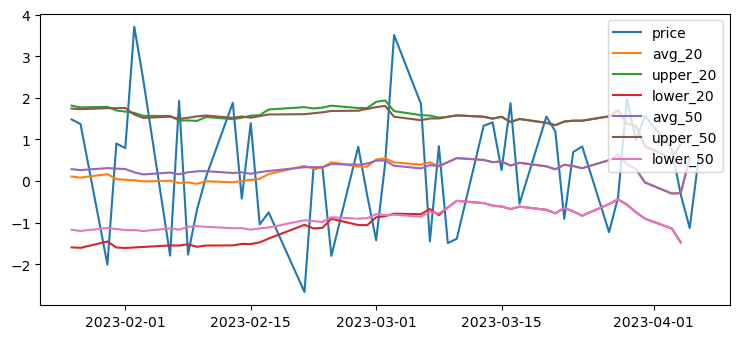

In [37]:
from matplotlib import pyplot as plt
# plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

df_appl = df_appl.tail(100)

line, = plt.plot(df_appl['date'], df_appl['close_percent_change'], label="price")  # Plot the chart
line, = plt.plot(df_appl['date'], df_appl['avg_close_percent_change_20'], label="avg_20")  # Plot the chart
line, = plt.plot(df_appl['date'], 
         df_appl['avg_close_percent_change_20'] + df_appl['stddev_close_percent_change_20']
        , label="upper_20")  # Plot the chart
line, = plt.plot(df_appl['date'], 
         df_appl['avg_close_percent_change_20'] - df_appl['stddev_close_percent_change_20']
        , label="lower_20")  # Plot the chart

line, = plt.plot(df_appl['date'], df_appl['avg_close_percent_change_50'], label="avg_50")  # Plot the chart

line, = plt.plot(df_appl['date'], 
         df_appl['avg_close_percent_change_50'] + df_appl['stddev_close_percent_change_50']
        , label="upper_50")  # Plot the chart
line, = plt.plot(df_appl['date'], 
         df_appl['avg_close_percent_change_50'] - df_appl['stddev_close_percent_change_50']
        , label="lower_50")  # Plot the chart
leg = plt.legend(loc='upper right')

plt.show()  # display

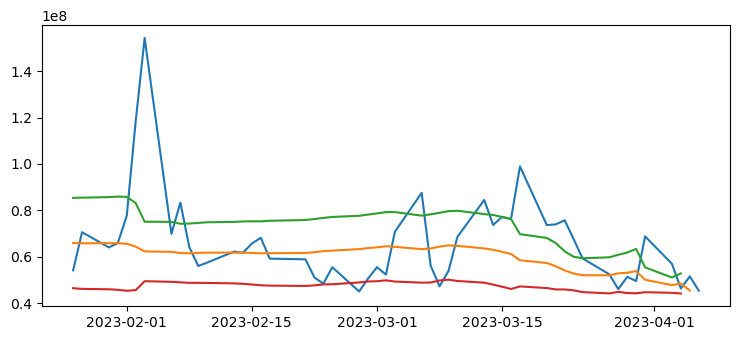

In [38]:
line, = plt.plot(df_appl['date'], df_appl['volume'], label="volume")  # Plot the chart
line, = plt.plot(df_appl['date'], df_appl['avg_volume_100'], label="avg_volume_100")  # Plot the chart
line, = plt.plot(df_appl['date'], 
         df_appl['avg_volume_100'] + df_appl['stddev_volume_100']
        , label="upper_20")  # Plot the chart
line, = plt.plot(df_appl['date'], 
         df_appl['avg_volume_100'] - df_appl['stddev_volume_100']
        , label="lower_20")  # Plot the chart


plt.show()  # display

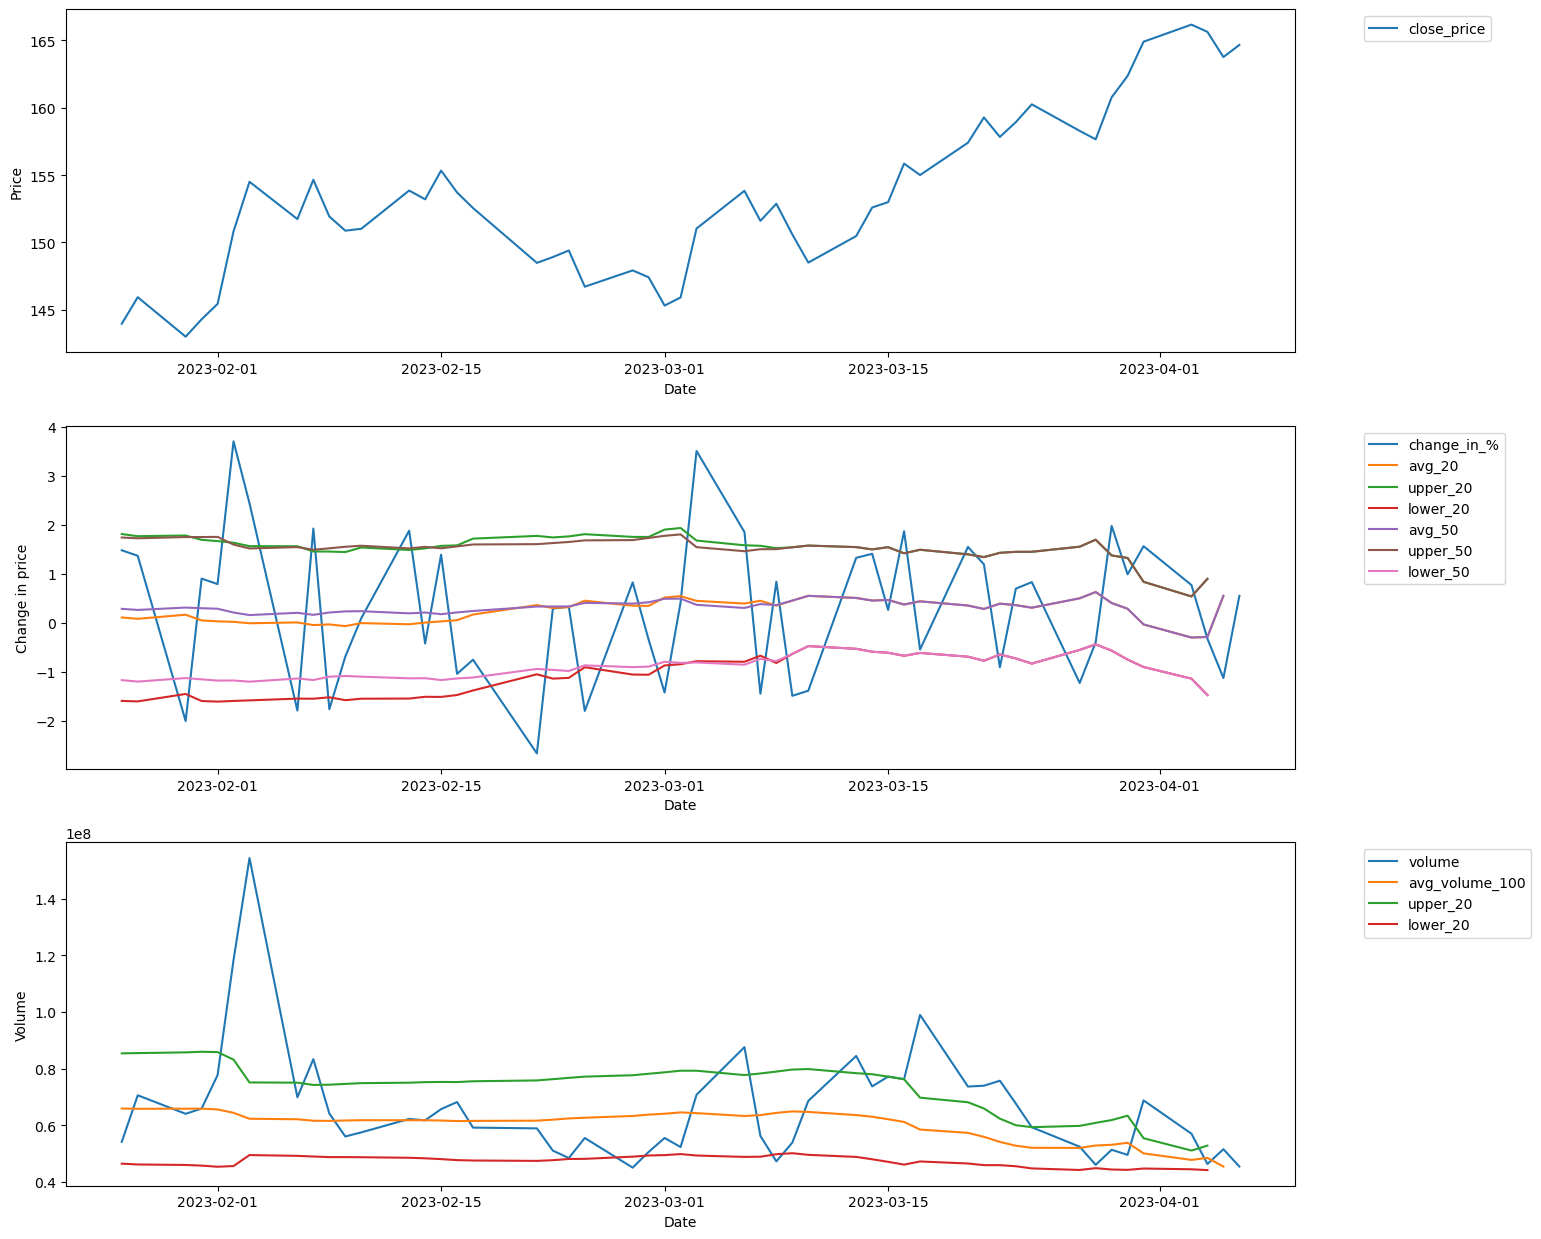

In [66]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(3, 1)
plt.rcParams["figure.figsize"] = [15.50, 12.50]

line, = axs[0].plot(df_appl['date'], df_appl['close'], label="close_price")  # Plot the chart

axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price')


line, = axs[1].plot(df_appl['date'], df_appl['close_percent_change'], label="change_in_%")  # Plot the chart
line, = axs[1].plot(df_appl['date'], df_appl['avg_close_percent_change_20'], label="avg_20")  # Plot the chart
line, = axs[1].plot(df_appl['date'], 
         df_appl['avg_close_percent_change_20'] + df_appl['stddev_close_percent_change_20']
        , label="upper_20")  # Plot the chart
line, = axs[1].plot(df_appl['date'], 
         df_appl['avg_close_percent_change_20'] - df_appl['stddev_close_percent_change_20']
        , label="lower_20")  # Plot the chart

line, = axs[1].plot(df_appl['date'], df_appl['avg_close_percent_change_50'], label="avg_50")  # Plot the chart

line, = axs[1].plot(df_appl['date'], 
         df_appl['avg_close_percent_change_50'] + df_appl['stddev_close_percent_change_50']
        , label="upper_50")  # Plot the chart
line, = axs[1].plot(df_appl['date'], 
         df_appl['avg_close_percent_change_50'] - df_appl['stddev_close_percent_change_50']
        , label="lower_50")  # Plot the chart

axs[1].set_xlabel('Date')
axs[1].set_ylabel('Change in price')

line, = axs[2].plot(df_appl['date'], df_appl['volume'], label="volume")  # Plot the chart
line, = axs[2].plot(df_appl['date'], df_appl['avg_volume_100'], label="avg_volume_100")  # Plot the chart
line, = axs[2].plot(df_appl['date'], 
         df_appl['avg_volume_100'] + df_appl['stddev_volume_100']
        , label="upper_20")  # Plot the chart
line, = axs[2].plot(df_appl['date'], 
         df_appl['avg_volume_100'] - df_appl['stddev_volume_100']
        , label="lower_20")  # Plot the chart

axs[2].set_xlabel('Date')
axs[2].set_ylabel('Volume')

leg = axs[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
leg = axs[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
leg = axs[2].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.show()  # display